In [1]:
# In a new cell: Basic Imports and Setup
import os
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy

# Add project root to path to import custom utils
try:
    PROJECT_ROOT = Path(__file__).parent.parent.parent
except NameError:
    PROJECT_ROOT = Path.cwd().parent.parent

sys.path.insert(0, str(PROJECT_ROOT))
print(f"Project Root: {PROJECT_ROOT}")

from utils.experiment_manager import ExperimentManager
from utils.experiment_analysis import ExperimentAnalyzer

# Set plotting style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")
sns.set_style("whitegrid")

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_

Project Root: /home/minhang/mds_project/sc_classification


In [2]:
#  --- Base Directory ---
BASE_EXPERIMENT_DIR = PROJECT_ROOT / "experiments"

# --- Experiment Metadata ---
# This dictionary will store information about each experiment run
experiments = {
    "pan_patient_all_filtered": {
        "id": "20250814_221408_fa_100_none_all_filtered_394c18e2",
        "label": "Pan-Patient (All Filtered Genes)",
        "type": "pan-patient"
    },
    "per_patient_all_filtered": {
        "id": "20250815_004248_fa_100_random_all_filtered_f77df82f",
        "label": "Per-Patient (All Filtered Genes)",
        "type": "per-patient"
    },
    "per_patient_deg_weak": {
        "id": "20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81",
        "label": "Per-Patient (DEG Weak Screen)",
        "type": "per-patient"
    }
}

# --- Initialize Managers ---
manager = ExperimentManager(BASE_EXPERIMENT_DIR)
analyzer = ExperimentAnalyzer(manager)

print("Setup complete. Experiments to analyze:")
for key, data in experiments.items():
    print(f"- {key}: {data['id']}")

Setup complete. Experiments to analyze:
- pan_patient_all_filtered: 20250814_221408_fa_100_none_all_filtered_394c18e2
- per_patient_all_filtered: 20250815_004248_fa_100_random_all_filtered_f77df82f
- per_patient_deg_weak: 20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81


In [3]:
# In a new cell: Check Preprocessing and Gene Filtering Results
print("--- Inspecting Gene Filtering from Preprocessing ---")

# We'll inspect the pan-patient run, but any of them would work
exp_id_to_check = experiments["pan_patient_all_filtered"]["id"]
exp = manager.load_experiment(exp_id_to_check)

# --- CORRECTED PATH CONSTRUCTION ---
# The path to dimension reduction results is based on the experiment config
dim_red_config = exp.config.get('dimension_reduction', {})
method = dim_red_config.get('method', 'fa')
n_components = dim_red_config.get('n_components', 100)
dim_red_dir_name = f"{method}_{n_components}"
# Construct the full path
transformed_data_path = exp.experiment_dir / "models" / dim_red_dir_name / "transformed_data.h5ad"


if transformed_data_path.exists():
    adata_transformed = sc.read_h5ad(transformed_data_path)
    
    print(f"\nAnalysis of transformed data from experiment: {exp_id_to_check}")
    print(f"Data shape (cells x factors): {adata_transformed.shape}")
    
    # The '.var' dataframe in the transformed adata contains the genes used for FA
    print(f"Number of genes used as input to Factor Analysis: {adata_transformed.var.shape[0]}")
    print("\nColumns available in adata.var (gene metadata):")
    print(adata_transformed.var.columns.tolist())
    
    print("\nPreview of gene metadata:")
    print(adata_transformed.var.head())
    
else:
    print(f"Could not find transformed data at: {transformed_data_path}")


--- Inspecting Gene Filtering from Preprocessing ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2

Analysis of transformed data from experiment: 20250814_221408_fa_100_none_all_filtered_394c18e2
Data shape (cells x factors): (69801, 10950)
Number of genes used as input to Factor Analysis: 10950

Columns available in adata.var (gene metadata):
['ID', 'modality', 'chr', 'start', 'end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'communality']

Preview of gene metadata:
                     ID         modality    chr      start        end  \
A1BG    ENSG00000121410  Gene Expression  chr19   58353491   58353492   
A4GALT  ENSG00000128274  Gene Expression  chr22   42694985   42720870   
AAAS    ENSG00000094914  Gene Expression  chr12   53321298   53324758   
AACS    ENSG00000081760  Gene Expression  chr12  125065434  12

In [4]:
# In a new cell: Inspect transformed_adata for per-patient experiments
print("--- Inspecting Gene Filtering for Per-Patient Experiments ---")

per_patient_exp_keys = ["per_patient_all_filtered", "per_patient_deg_weak"]

for key in per_patient_exp_keys:
    exp_data = experiments[key]
    exp_id = exp_data["id"]
    exp = manager.load_experiment(exp_id)

    # Construct the path to the transformed data
    dim_red_config = exp.config.get('dimension_reduction', {})
    method = dim_red_config.get('method', 'fa')
    n_components = dim_red_config.get('n_components', 100)
    dim_red_dir_name = f"{method}_{n_components}"
    transformed_data_path = exp.experiment_dir / "models" / dim_red_dir_name / "transformed_data.h5ad"

    if transformed_data_path.exists():
        adata_transformed = sc.read_h5ad(transformed_data_path)
        print(f"\nAnalysis for experiment: {exp_data['label']} ({exp_id})")
        print(f"  Data shape (cells x factors): {adata_transformed.shape}")
        print(f"  Number of genes used as input to Factor Analysis: {adata_transformed.var.shape[0]}")
    else:
        print(f"\nCould not find transformed data for {exp_data['label']} at: {transformed_data_path}")

--- Inspecting Gene Filtering for Per-Patient Experiments ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f

Analysis for experiment: Per-Patient (All Filtered Genes) (20250815_004248_fa_100_random_all_filtered_f77df82f)
  Data shape (cells x factors): (69801, 10950)
  Number of genes used as input to Factor Analysis: 10950
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81

Analysis for experiment: Per-Patient (DEG Weak Screen) (20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81)
  Data shape (cells x factors): (69801, 5202)
  Number of genes used as input to Factor Analysis: 5202


--- Generating Factor Analysis Diagnostic Plots ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81


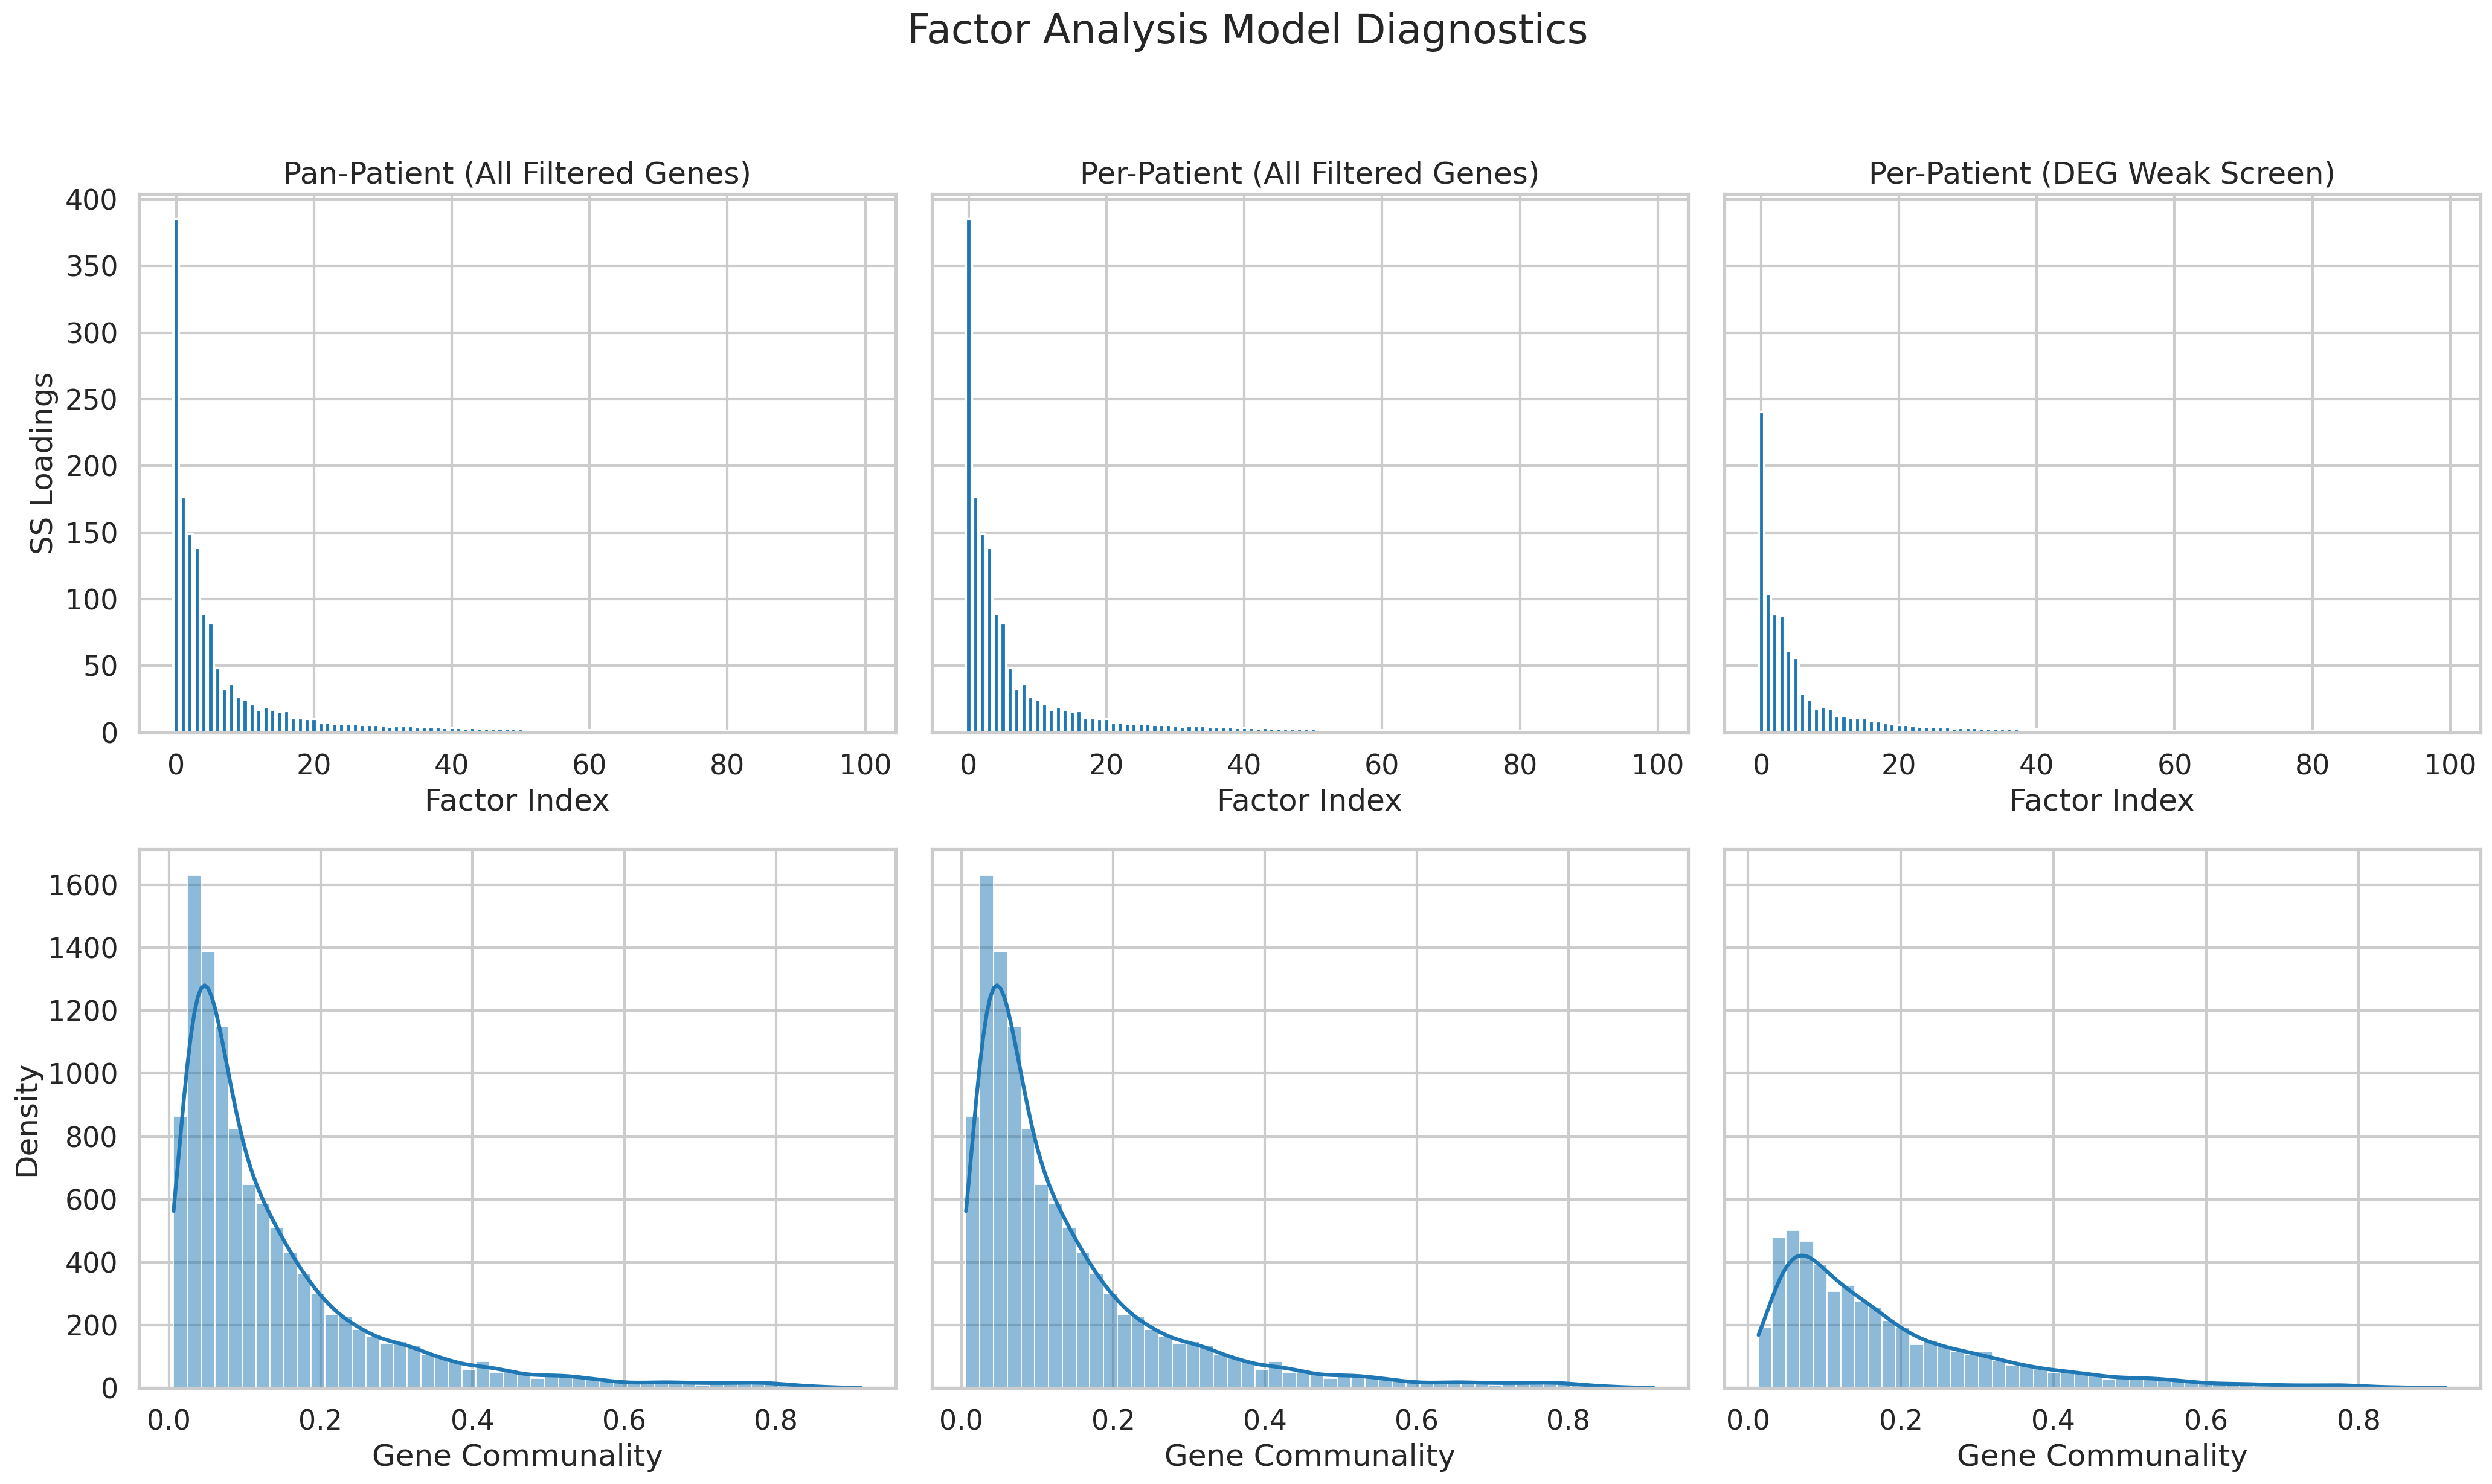

In [5]:
# In a new cell: Generate FA Diagnostic Plots
print("--- Generating Factor Analysis Diagnostic Plots ---")

num_experiments = len(experiments)
fig, axes = plt.subplots(2, num_experiments, figsize=(7 * num_experiments, 12), sharey='row')
fig.suptitle("Factor Analysis Model Diagnostics", fontsize=24, y=1.03)

for i, (key, exp_data) in enumerate(experiments.items()):
    exp_id = exp_data["id"]
    exp = manager.load_experiment(exp_id)
    
    # --- CORRECTED PATH CONSTRUCTION ---
    dim_red_config = exp.config.get('dimension_reduction', {})
    method = dim_red_config.get('method', 'fa')
    n_components = dim_red_config.get('n_components', 100)
    dim_red_dir_name = f"{method}_{n_components}"
    adata_path = exp.experiment_dir / "models" / dim_red_dir_name / "transformed_data.h5ad"
    
    if not adata_path.exists():
        print(f"Transformed data not found for {exp_id}, skipping.")
        axes[0, i].set_title(f"{exp_data['label']}\n(Data not found)")
        axes[0, i].axis('off')
        axes[1, i].axis('off')
        continue

    adata = sc.read_h5ad(adata_path)

    # Panel 1: Sum of Square (SS) Loadings per Factor
    if 'fa' in adata.uns and 'ss_loadings_per_factor' in adata.uns['fa']:
        ss_loadings = adata.uns['fa']['ss_loadings_per_factor']
        axes[0, i].bar(range(len(ss_loadings)), ss_loadings)
        axes[0, i].set_title(exp_data['label'])
        axes[0, i].set_xlabel("Factor Index")
    else:
        axes[0, i].set_title(f"{exp_data['label']}\n(SS Loadings not found)")

    # Panel 2: Gene Communality Distribution
    if 'communality' in adata.var:
        communality = adata.var['communality']
        sns.histplot(communality, ax=axes[1, i], bins=50, kde=True)
        axes[1, i].set_xlabel("Gene Communality")
    else:
         axes[1, i].set_title(f"(Communality not found)")


# Set shared Y-axis labels
axes[0, 0].set_ylabel("SS Loadings")
axes[1, 0].set_ylabel("Density")

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [ ]:
# In a new cell: Run GSEA on Factors for each experiment
print("\n--- Running GSEA on Factors for All Experiments ---")

# This assumes 'manager' is your initialized ExperimentManager instance
# and 'experiments' is the dictionary of experiments defined earlier in the notebook.
try:
    analyzer = ExperimentAnalyzer(manager)
except NameError:
    print("Could not find 'ExperimentAnalyzer'. Make sure it is imported and initialized.")
    # Assuming it's in utils.experiment_analysis and needs the manager
    # from utils.experiment_analysis import ExperimentAnalyzer
    # analyzer = ExperimentAnalyzer(manager)


for key, exp_data in experiments.items():
    exp_id = exp_data["id"]
    print(f"\n--- Processing Experiment: {exp_data['label']} ({exp_id}) ---")
    
    # Run with original loadings
    analyzer.run_gsea_on_factors(
        experiment_id=exp_id,
        rescale_loadings=False
    )
    
    # Run with rescaled loadings
    #analyzer.run_gsea_on_factors(
    #    experiment_id=exp_id,
   #     rescale_loadings=True
   # )

print("\n--- GSEA on Factors Analysis Complete ---")


--- Running GSEA on Factors for All Experiments ---

--- Processing Experiment: Pan-Patient (All Filtered Genes) (20250814_221408_fa_100_none_all_filtered_394c18e2) ---
--- Running GSEA on All Factors (Original Loadings) for Experiment: 20250814_221408_fa_100_none_all_filtered_394c18e2 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Running GSEA on factor: X_fa_1


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_2


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_3


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_4


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_5


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_6


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_7


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_8


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_9


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_10


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_11


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_12


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_13


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_14


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_15


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_16


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_17


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_18


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_19


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_20


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_21


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_22


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_23


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_24


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_25


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_26


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_27


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_28


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_29


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_30


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_31


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_32


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_33


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_34


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_35


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_36


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_37


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_38


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_39


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_40


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_41


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_42


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_43


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_44


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_45


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_46


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_47


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_48


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_49


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_50


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_51


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_52


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_53


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_54


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_55


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_56


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_57


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_58


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_59


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_60


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_61


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_62


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_63


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_64


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_65


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_66


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_67


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_68


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_69


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_70


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_71


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_72


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_73


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_74


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_75


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_76


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_77


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_78


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_79


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_80


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_81


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_82


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_83


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_84


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_85


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_86


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_87


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_88


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_89


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_90


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_91


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_92


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_93


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_94


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_95


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_96


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_97


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_98


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_99


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_100


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')



Generated summary plot of significant hits: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/factor_interpretation/gsea_on_factors_original/summary_significant_hits_original.png
--- Running GSEA on All Factors (Rescaled Loadings) for Experiment: 20250814_221408_fa_100_none_all_filtered_394c18e2 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Rescaling factor loadings to common [-1, 1] scale...
  Running GSEA on factor: X_fa_1


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_2


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_3


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_4


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_5


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_6


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_7


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_8


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_9


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_10


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_11


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_12


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_13


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_14


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_15


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_16


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_17


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_18


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_19


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_20


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_21


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_22


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_23


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_24


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_25


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_26


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_27


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_28


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_29


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_30


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_31


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_32


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_33


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_34


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_35


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_36


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_37


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_38


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_39


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_40


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_41


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_42


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_43


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_44


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_45


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_46


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_47


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_48


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_49


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_50


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_51


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_52


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_53


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_54


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_55


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_56


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_57


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_58


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_59


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_60


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_61


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_62


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_63


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_64


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_65


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_66


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_67


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_68


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_69


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_70


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_71


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_72


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_73


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_74


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_75


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_76


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_77


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_78


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_79


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_80


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_81


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_82


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_83


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_84


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_85


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_86


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_87


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_88


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_89


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_90


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_91


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_92


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_93


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_94


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_95


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_96


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_97


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_98


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_99


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_100


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')



Generated summary plot of significant hits: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/factor_interpretation/gsea_on_factors_rescaled/summary_significant_hits_rescaled.png

--- Processing Experiment: Per-Patient (All Filtered Genes) (20250815_004248_fa_100_random_all_filtered_f77df82f) ---
--- Running GSEA on All Factors (Original Loadings) for Experiment: 20250815_004248_fa_100_random_all_filtered_f77df82f ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Running GSEA on factor: X_fa_1


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_2


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_3


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_4


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_5


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_6


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_7


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_8


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_9


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_10


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_11


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_12


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_13


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_14


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_15


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_16


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_17


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_18


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_19


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_20


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_21


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_22


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_23


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_24


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_25


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_26


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_27


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_28


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_29


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_30


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_31


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_32


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_33


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_34


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_35


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_36


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_37


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_38


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_39


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_40


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_41


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_42


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_43


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_44


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_45


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_46


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_47


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_48


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_49


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_50


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_51


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_52


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_53


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_54


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_55


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_56


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_57


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_58


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_59


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_60


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_61


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_62


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_63


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_64


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_65


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_66


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_67


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_68


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_69


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_70


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_71


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_72


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_73


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_74


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_75


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_76


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_77


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_78


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_79


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_80


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_81


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_82


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_83


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_84


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_85


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_86


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_87


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_88


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_89


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_90


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_91


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_92


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_93


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_94


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_95


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_96


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_97


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_98


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_99


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_100


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')



Generated summary plot of significant hits: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/factor_interpretation/gsea_on_factors_original/summary_significant_hits_original.png
--- Running GSEA on All Factors (Rescaled Loadings) for Experiment: 20250815_004248_fa_100_random_all_filtered_f77df82f ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Rescaling factor loadings to common [-1, 1] scale...
  Running GSEA on factor: X_fa_1


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_2


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_3


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_4


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_5


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_6


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_7


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_8


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_9


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_10


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_11


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_12


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_13


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_14


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_15


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_16


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_17


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_18


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_19


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_20


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_21


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_22


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_23


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_24


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_25


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_26


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_27


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_28


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_29


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_30


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_31


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_32


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_33


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_34


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_35


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_36


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_37


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_38


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_39


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_40


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_41


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_42


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_43


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_44


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_45


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_46


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_47


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_48


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_49


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_50


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_51


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_52


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_53


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_54


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_55


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_56


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_57


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_58


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_59


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_60


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_61


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_62


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_63


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_64


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_65


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_66


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_67


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_68


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_69


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_70


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_71


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_72


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_73


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_74


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_75


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_76


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_77


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_78


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_79


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_80


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_81


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_82


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_83


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_84


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_85


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_86


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_87


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_88


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_89


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_90


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_91


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_92


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_93


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_94


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_95


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_96


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_97


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_98


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_99


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_100


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')



Generated summary plot of significant hits: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/factor_interpretation/gsea_on_factors_rescaled/summary_significant_hits_rescaled.png

--- Processing Experiment: Per-Patient (DEG Weak Screen) (20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81) ---
--- Running GSEA on All Factors (Original Loadings) for Experiment: 20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81
  Running GSEA on factor: X_fa_1


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_2


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_3


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_4


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_5


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_6


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_7


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_8


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_9


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_10


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_11


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_12


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_13


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_14


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_15


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_16


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_17


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_18


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_19


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_20


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_21


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_22


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_23


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_24


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_25


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_26


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_27


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_28


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_29


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_30


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_31


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_32


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_33


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_34


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_35


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_36


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_37


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_38


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_39


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_40


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_41


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_42


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_43


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_44


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_45


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_46


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_47


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_48


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_49


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_50


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_51


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_52


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_53


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_54


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_55


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_56


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_57


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_58


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_59


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_60


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_61


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_62


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_63


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_64


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_65


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_66


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_67


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_68


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_69


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_70


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_71


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_72


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_73


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_74


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_75


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_76


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_77


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_78


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_79


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_80


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_81


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_82


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_83


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_84


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_85


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_86


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_87


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_88


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_89


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_90


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_91


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_92


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_93


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_94


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_95


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_96


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_97


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_98


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_99


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_100


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')



Generated summary plot of significant hits: /home/minhang/mds_project/sc_classification/experiments/20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81/analysis/factor_interpretation/gsea_on_factors_original/summary_significant_hits_original.png
--- Running GSEA on All Factors (Rescaled Loadings) for Experiment: 20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81
  Rescaling factor loadings to common [-1, 1] scale...
  Running GSEA on factor: X_fa_1


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_2


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_3


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_4


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_5


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_6


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_7


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_8


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_9


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_10


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_11


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_12


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_13


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_14


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_15


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_16


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_17


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_18


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_19


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_20


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_21


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_22


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_23


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_24


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_25


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_26


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_27


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_28


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_29


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_30


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_31


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_32


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_33


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_34


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_35


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_36


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_37


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_38


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_39


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_40


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_41


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_42


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_43


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_44


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_45


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_46


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_47


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_48


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_49


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_50


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_51


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_52


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_53


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_54


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_55


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_56


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_57


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_58


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_59


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_60


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_61


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_62


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_63


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_64


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_65


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_66


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_67


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_68


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_69


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_70


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_71


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_72


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_73


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_74


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_75


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_76


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_77


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_78


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_79


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_80


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_81


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_82


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_83


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_84


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_85


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_86


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_87


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_88


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_89


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_90


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_91


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_92


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_93


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_94


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_95


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_96


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_97


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_98


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_99


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Running GSEA on factor: X_fa_100


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')



Generated summary plot of significant hits: /home/minhang/mds_project/sc_classification/experiments/20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81/analysis/factor_interpretation/gsea_on_factors_rescaled/summary_significant_hits_rescaled.png

--- GSEA on Factors Analysis Complete ---


In [6]:
# In a new cell: Generate 2-Panel Lasso Path Reports
print("--- Generating 2-Panel LASSO Path Reports for All Experiments ---")

for key, exp_data in experiments.items():
    exp_id = exp_data["id"]
    print(f"\nProcessing experiment: {exp_data['label']} ({exp_id})")
    try:
        analyzer.generate_lasso_path_2panels_report(exp_id)
    except Exception as e:
        print(f"  ERROR: Could not generate report for {exp_id}. Reason: {e}")

print("\n--- Report generation complete. ---")
print("Check the 'summary_plots' directory within each experiment folder.")


--- Generating 2-Panel LASSO Path Reports for All Experiments ---

Processing experiment: Pan-Patient (All Filtered Genes) (20250814_221408_fa_100_none_all_filtered_394c18e2)
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2

Processing experiment: Per-Patient (All Filtered Genes) (20250815_004248_fa_100_random_all_filtered_f77df82f)
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f

Processing experiment: Per-Patient (DEG Weak Screen) (20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81)
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_005818_fa_100_random_deg_weak_screen_5b5a8e81

--- Report generation complete. ---
Check the 'summary_plots' directory within each experiment folder.


In [9]:
# In a new cell: Define Selected Regularization Strength Indices

# For the pan-patient run
pan_patient_indices = list(range(12, 19))

# For the per-patient "all_filtered" run
per_patient_all_filtered_indices = {
    'P01': list(range(8, 15)),
    'P02': list(range(12, 17)),
    'P03': [17],
    'P04': list(range(9, 15)),
    'P05': list(range(10, 14)),
    'P06': list(range(9, 14)),
    'P07': [11, 12, 13],
    'P09': list(range(12, 17)),
    'P13': list(range(10, 14))
}

# For the per-patient "deg_weak_screen" run
per_patient_deg_weak_indices = {
    'P01': list(range(10, 15)),
    'P02': list(range(13, 17)),
    'P03': list(range(11, 18)),
    'P04': list(range(10, 15)),
    'P05': list(range(9, 15)),
    'P06': [10, 11, 12, 13],
    'P07': [10, 11, 12, 13],
    'P09': list(range(11, 18)),
    'P13': [10, 11, 12, 13]
}

# Store these in our main experiments dictionary for easy access
experiments["pan_patient_all_filtered"]["indices"] = pan_patient_indices
experiments["per_patient_all_filtered"]["indices"] = per_patient_all_filtered_indices
experiments["per_patient_deg_weak"]["indices"] = per_patient_deg_weak_indices

print("Regularization indices have been defined and stored.")
print("\nPan-Patient Indices:", pan_patient_indices)
print("\nPer-Patient 'All Filtered' Indices:", per_patient_all_filtered_indices)
print("\nPer-Patient 'DEG Weak' Indices:", per_patient_deg_weak_indices)


Regularization indices have been defined and stored.

Pan-Patient Indices: [12, 13, 14, 15, 16, 17, 18]

Per-Patient 'All Filtered' Indices: {'P01': [8, 9, 10, 11, 12, 13, 14], 'P02': [12, 13, 14, 15, 16], 'P03': [17], 'P04': [9, 10, 11, 12, 13, 14], 'P05': [10, 11, 12, 13], 'P06': [9, 10, 11, 12, 13], 'P07': [11, 12, 13], 'P09': [12, 13, 14, 15, 16], 'P13': [10, 11, 12, 13]}

Per-Patient 'DEG Weak' Indices: {'P01': [10, 11, 12, 13, 14], 'P02': [13, 14, 15, 16], 'P03': [11, 12, 13, 14, 15, 16, 17], 'P04': [10, 11, 12, 13, 14], 'P05': [9, 10, 11, 12, 13, 14], 'P06': [10, 11, 12, 13], 'P07': [10, 11, 12, 13], 'P09': [11, 12, 13, 14, 15, 16, 17], 'P13': [10, 11, 12, 13]}


In [11]:
# In a new cell: Run Downstream Classification Analysis (Corrected)

for key, exp_data in experiments.items():
    exp_id = exp_data["id"]
    indices = exp_data["indices"]
    
    print(f"\n{'='*80}")
    print(f"--- Starting Downstream Analysis for: {exp_data['label']} ({exp_id}) ---")
    print(f"{'='*80}")

    # Determine if this is a pan-patient or per-patient run to structure the loops correctly
    is_pan_patient = exp_data["type"] == "pan-patient"
    
    # For pan-patient, we use a dictionary with a single key.
    # For per-patient, the indices object is already a dictionary.
    if is_pan_patient:
        patient_indices_dict = {'all_patients': indices}
    else:
        patient_indices_dict = indices

    # --- 1. Analyze Classification Transitions ---
    print("\n--- 1. Analyzing classification transitions ---")
    try:
        # Loop over each patient/group and their corresponding indices
        for patient_id, indices_to_check in patient_indices_dict.items():
            print(f"  Analyzing transitions for patient/group: {patient_id}")
            analyzer.analyze_classification_transitions(
                experiment_id=exp_id,
                patient_id=patient_id,
                indices_to_check=indices_to_check
            )
        print("  Transition analysis complete.")
    except Exception as e:
        print(f"  ERROR during transition analysis: {e}")

    # --- 2. Generate Classification UMAP Reports ---
    print("\n--- 2. Generating classification UMAP reports ---")
    try:
        # This function correctly takes a dictionary for both pan- and per-patient runs
        analyzer.generate_classification_umap_report(
            experiment_id=exp_id,
            patient_reg_strength_indices=patient_indices_dict,
            static_umap_rep='X_multivi'
        )
        print("  UMAP report generation complete.")
    except Exception as e:
        print(f"  ERROR during UMAP report generation: {e}")

    # --- 3. Run GSEA on Predictive Loadings ---
    print("\n--- 3. Running GSEA on predictive factor loadings ---")
    try:
        # Loop over each patient/group
        for patient_id, indices_to_check in patient_indices_dict.items():
            print(f"  Running GSEA for patient/group: {patient_id}")
            # Loop over each individual index for the patient/group
            for alpha_idx in indices_to_check:
                analyzer.run_gsea_on_predictive_loading(
                    experiment_id=exp_id,
                    patient_id=patient_id,
                    alpha_index=alpha_idx
                )
        print("  GSEA analysis complete.")
    except Exception as e:
        print(f"  ERROR during GSEA: {e}")

print(f"\n{'='*80}")
print("--- All Analyses Finished ---")
print("Check the 'analysis' directory within each experiment folder for results.")
print(f"{'='*80}")


--- Starting Downstream Analysis for: Pan-Patient (All Filtered Genes) (20250814_221408_fa_100_none_all_filtered_394c18e2) ---

--- 1. Analyzing classification transitions ---
  Analyzing transitions for patient/group: all_patients
--- Analyzing Classification Transitions for Patient all_patients ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Analyzing transition from index 18 to 17...
  Analyzing transition from index 17 to 16...
  Analyzing transition from index 16 to 15...
  Analyzing transition from index 15 to 14...
  Analyzing transition from index 14 to 13...
  Analyzing transition from index 13 to 12...

Successfully saved transition analysis to: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/models/classification/all_patients/classification_transitions.json
  Transition analysis complete.

--- 2. Generating classification UMAP re

/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/supervised_gsea/all_patients/alpha_idx_12
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 13 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/supervised_gsea/all_patients/alpha_idx_13
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 14 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/supervised_gsea/all_patients/alpha_idx_14
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 15 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/supervised_gsea/all_patients/alpha_idx_15
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 16 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/supervised_gsea/all_patients/alpha_idx_16
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 17 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/supervised_gsea/all_patients/alpha_idx_17
--- Running GSEA on Predictive Loading for Patient all_patients at alpha index 18 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250814_221408_fa_100_none_all_filtered_394c18e2/analysis/supervised_gsea/all_patients/alpha_idx_18
  GSEA analysis complete.

--- Starting Downstream Analysis for: Per-Patient (All Filtered Genes) (20250815_004248_fa_100_random_all_filtered_f77df82f) ---

--- 1. Analyzing classification transitions ---
  Analyzing transitions for patient/group: P01
--- Analyzing Classification Transitions for Patient P01 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Analyzing transition from index 14 to 13...
  Analyzing transition from index 13 to 12...
  Analyzing transition from index 12 to 11...
  Analyzing transition from index 11 to 10...
  Analyzing transition from index 10 to 9...
  Analyzing transition from index 9 to 8...

Successfully saved transition analysis to: /home/minhang/mds_project/sc_clas

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P01.

Processing patient: P02
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 16: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P02.

Processing patient: P03
  Generating Dynamic UMAPs based on selected 'fa' factors
    Index 17: Only 1 active factor. Attempting fallback.


/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


  Finished dynamic UMAPs for patient P03.

Processing patient: P04
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P04.

Processing patient: P05
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P05.

Processing patient: P06
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P06.

Processing patient: P07
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P07.

Processing patient: P09
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P09.

Processing patient: P13
  Generating Dynamic UMAPs based on selected 'fa' factors
  Finished dynamic UMAPs for patient P13.

--- Report generation complete. ---
  UMAP report generation complete.

--- 3. Running GSEA on predictive factor loadings ---
  Running GSEA for patient/group: P01
--- Running GSEA on Predictive Loading for 

/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P01/alpha_idx_8
--- Running GSEA on Predictive Loading for Patient P01 at alpha index 9 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P01/alpha_idx_9
--- Running GSEA on Predictive Loading for Patient P01 at alpha index 10 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P01/alpha_idx_10
--- Running GSEA on Predictive Loading for Patient P01 at alpha index 11 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P01/alpha_idx_11
--- Running GSEA on Predictive Loading for Patient P01 at alpha index 12 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P01/alpha_idx_12
--- Running GSEA on Predictive Loading for Patient P01 at alpha index 13 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P01/alpha_idx_13
--- Running GSEA on Predictive Loading for Patient P01 at alpha index 14 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P01/alpha_idx_14
  Running GSEA for patient/group: P02
--- Running GSEA on Predictive Loading for Patient P02 at alpha index 12 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P02/alpha_idx_12
--- Running GSEA on Predictive Loading for Patient P02 at alpha index 13 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P02/alpha_idx_13
--- Running GSEA on Predictive Loading for Patient P02 at alpha index 14 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P02/alpha_idx_14
--- Running GSEA on Predictive Loading for Patient P02 at alpha index 15 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P02/alpha_idx_15
--- Running GSEA on Predictive Loading for Patient P02 at alpha index 16 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P02/alpha_idx_16
  Running GSEA for patient/group: P03
--- Running GSEA on Predictive Loading for Patient P03 at alpha index 17 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P03/alpha_idx_17
  Running GSEA for patient/group: P04
--- Running GSEA on Predictive Loading for Patient P04 at alpha index 9 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P04/alpha_idx_9
--- Running GSEA on Predictive Loading for Patient P04 at alpha index 10 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P04/alpha_idx_10
--- Running GSEA on Predictive Loading for Patient P04 at alpha index 11 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P04/alpha_idx_11
--- Running GSEA on Predictive Loading for Patient P04 at alpha index 12 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P04/alpha_idx_12
--- Running GSEA on Predictive Loading for Patient P04 at alpha index 13 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P04/alpha_idx_13
--- Running GSEA on Predictive Loading for Patient P04 at alpha index 14 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P04/alpha_idx_14
  Running GSEA for patient/group: P05
--- Running GSEA on Predictive Loading for Patient P05 at alpha index 10 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P05/alpha_idx_10
--- Running GSEA on Predictive Loading for Patient P05 at alpha index 11 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P05/alpha_idx_11
--- Running GSEA on Predictive Loading for Patient P05 at alpha index 12 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f
  Calculating predictive loading vector...
  Running GSEA...


/home/minhang/mds_project/sc_classification/utils/experiment_analysis.py:1962: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='NES', y='Term', data=combined, palette=colors, orient='h')


  Successfully ran supervised GSEA. Results in /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f/analysis/supervised_gsea/P05/alpha_idx_12
--- Running GSEA on Predictive Loading for Patient P05 at alpha index 13 ---
Loading experiment from: /home/minhang/mds_project/sc_classification/experiments/20250815_004248_fa_100_random_all_filtered_f77df82f


: 